In [ ]:
# === 手順1: 環境構築 ===
# 1. 競合するライブラリを削除
!pip uninstall -y python-snappy snappy

# 2. 必要なシステムライブラリとSnapPyをインストール
!apt-get install -y python3-tk
!pip install snappy networkx matplotlib

print("\n✅ インストール完了。")
print("⚠️ 重要: 上部のメニューから「ランタイム」→「セッションを再起動する」をクリックしてください。")
print("   (再起動しないと古いライブラリが残り、エラーになります)")

Found existing installation: python-snappy 0.7.3
Uninstalling python-snappy-0.7.3:
  Successfully uninstalled python-snappy-0.7.3
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  blt tk8.6-blt2.5
Suggested packages:
  blt-demo tix python3-tk-dbg
The following NEW packages will be installed:
  blt python3-tk tk8.6-blt2.5
0 upgraded, 3 newly installed, 0 to remove and 1 not upgraded.
Need to get 757 kB of archives.
After this operation, 2,920 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 tk8.6-blt2.5 amd64 2.5.3+dfsg-4.1build2 [643 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 blt amd64 2.5.3+dfsg-4.1build2 [4,838 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-tk amd64 3.10.8-1~22.04 [110 kB]
Fetched 757 kB in 1s (916 kB/s)
Selecting previously unselected package tk8.6-blt2.5.
(Reading database

5の字結び目 (5_1)

トレフォイル（3交点）の親戚で、星型のような形をした結び目です

initial_pd = [
        [2, 8, 3, 7], [4, 10, 5, 9], [6, 2, 7, 1],
        [8, 4, 9, 3], [10, 6, 1, 5]
    ]

✅ Correct SnapPy (Topology) loaded.
Target: Cinquefoil Knot (5_1)
=== Starting Vogel's Algorithm ===
Initial Crossings: 5

>>> CONVERGED! Closed Braid obtained.
Total Steps: 0

Result Braid Word: [1, 1, 1, 1, 1]
Drawing braid word: [1, 1, 1, 1, 1]


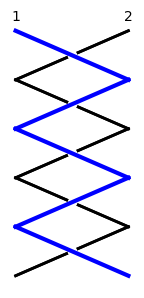

In [ ]:
# === 手順2: 完成版コード ===
import networkx as nx
import matplotlib.pyplot as plt
import copy
import os
import sys
from IPython.display import Image, display

# --- SnapPyの読み込みチェック ---
try:
    import snappy
    if hasattr(snappy, 'Link'):
        print("✅ Correct SnapPy (Topology) loaded.")
        SNAPPY_AVAILABLE = True
    else:
        print("❌ Error: Wrong SnapPy loaded. Please restart runtime.")
        SNAPPY_AVAILABLE = False
except ImportError:
    SNAPPY_AVAILABLE = False
    print("Warning: SnapPy not found.")

# --- Vogelアルゴリズムの実装 ---
class VogelBraidAlgorithm:
    def __init__(self, initial_pd_code):
        self.pd_code = copy.deepcopy(initial_pd_code)
        self.step_count = 0
        flattened = [x for crossing in self.pd_code for x in crossing]
        self.max_edge_id = max(flattened) if flattened else 0

    def analyze_state(self):
        # ザイフェルト円の検出
        seifert_graph = nx.DiGraph()
        seifert_graph.add_nodes_from(range(1, self.max_edge_id + 1))
        for crossing in self.pd_code:
            in1, in2, out1, out2 = crossing[0], crossing[1], crossing[3], crossing[2]
            seifert_graph.add_edge(in1, out1)
            seifert_graph.add_edge(in2, out2)
        try:
            circles = list(nx.simple_cycles(seifert_graph))
        except:
            circles = []
        n = len(circles)
        target_chi = (n + 1) * (n + 2) // 2
        return {"n": n, "circles": circles}

    def find_admissible_triple(self, circles):
        # 変形可能な箇所(Triple)を探す
        edge_to_circle = {}
        for idx, circle_edges in enumerate(circles):
            for edge in circle_edges:
                edge_to_circle[edge] = idx
        for crossing in self.pd_code:
            edges = crossing
            for i in range(4):
                edge_a = edges[i]
                edge_b = edges[(i + 1) % 4]
                c_a = edge_to_circle.get(edge_a)
                c_b = edge_to_circle.get(edge_b)
                if c_a is not None and c_b is not None and c_a != c_b:
                    return edge_a, edge_b
        return None, None

    def apply_move_T(self, alpha, beta):
        # 基本変形 T (交点追加)
        mid_a = self.max_edge_id + 1
        mid_b = self.max_edge_id + 2
        out_a = self.max_edge_id + 3
        out_b = self.max_edge_id + 4
        self.max_edge_id += 4
        self._update_connection(alpha, out_a)
        self._update_connection(beta, out_b)
        new_x = [alpha, beta, mid_b, mid_a]
        new_y = [mid_a, mid_b, out_b, out_a]
        self.pd_code.append(new_x)
        self.pd_code.append(new_y)

    def _update_connection(self, target_edge, new_edge):
        count = 0
        for i, crossing in enumerate(self.pd_code):
            for j, edge in enumerate(crossing):
                if edge == target_edge:
                    count += 1
                    if count == 2:
                        self.pd_code[i][j] = new_edge
                        return

    def run(self, max_steps=50):
        print(f"=== Starting Vogel's Algorithm ===")
        print(f"Initial Crossings: {len(self.pd_code)}")
        while self.step_count < max_steps:
            state = self.analyze_state()
            alpha, beta = self.find_admissible_triple(state['circles'])
            if alpha is None:
                print(f"\n>>> CONVERGED! Closed Braid obtained.")
                print(f"Total Steps: {self.step_count}")
                return self.pd_code
            self.step_count += 1
            # print(f"Step {self.step_count}...") # 詳細ログが必要ならコメントアウト解除
            self.apply_move_T(alpha, beta)
        print(">>> Reached max steps limit.")
        return self.pd_code

# --- 可視化関数 ---
def save_braid_image(braid_word, filename="braid_result.png"):
    if not braid_word: return
    print(f"Drawing braid word: {braid_word}")
    n_strands = max(abs(x) for x in braid_word) + 1
    fig, ax = plt.subplots(figsize=(n_strands * 0.8, len(braid_word) * 0.5 + 1))
    current_x = list(range(n_strands))
    y = 0
    for i in range(n_strands): ax.text(i, 0.2, f"{i+1}", ha='center')
    for op in braid_word:
        idx = abs(op) - 1
        next_y = y - 1
        for i in range(n_strands):
            if i != idx and i != idx + 1:
                ax.plot([current_x[i], current_x[i]], [y, next_y], 'k-', lw=2)
        lx, rx = current_x[idx], current_x[idx+1]
        if op > 0:
            ax.plot([lx, rx], [y, next_y], 'b-', lw=3, zorder=10)
            ax.plot([rx, lx], [y, next_y], 'k-', lw=2, zorder=5)
            ax.plot([(lx+rx)/2], [(y+next_y)/2], 'wo', ms=6, zorder=6)
            ax.plot([rx, lx], [y, next_y], 'k-', lw=2, zorder=5)
        else:
            ax.plot([rx, lx], [y, next_y], 'b-', lw=3, zorder=10)
            ax.plot([lx, rx], [y, next_y], 'k-', lw=2, zorder=5)
            ax.plot([(lx+rx)/2], [(y+next_y)/2], 'wo', ms=6, zorder=6)
            ax.plot([lx, rx], [y, next_y], 'k-', lw=2, zorder=5)
        current_x[idx], current_x[idx+1] = current_x[idx+1], current_x[idx]
        y = next_y
    ax.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

# --- メイン実行部 ---
def main():
    # 入力データ: 5の字結び目 (5_1)
    # 組み紐になるまで変形が必要な典型的な例
    initial_pd = [
        [2, 8, 3, 7], [4, 10, 5, 9], [6, 2, 7, 1],
        [8, 4, 9, 3], [10, 6, 1, 5]
    ]
    print("Target: Cinquefoil Knot (5_1)")

    # 1. アルゴリズム実行
    solver = VogelBraidAlgorithm(initial_pd)
    final_pd = solver.run()

    # 2. 解析と表示
    if SNAPPY_AVAILABLE:
        try:
            link = snappy.Link(final_pd)
            word = link.braid_word()
            print(f"\nResult Braid Word: {word}")
            save_braid_image(word, "braid_result.png")

            # 画像を表示
            display(Image("braid_result.png"))
        except Exception as e:
            print(f"Analysis Error: {e}")

if __name__ == "__main__":
    main()

8の字結び目 (Figure-8 knot, 4_1)

initial_pd = [
        [4, 2, 5, 1],
        [8, 6, 1, 5],
        [6, 3, 7, 4],
        [2, 7, 3, 8]
    ]

✅ Correct SnapPy (Topology) loaded.
Target Knot: Figure-8 (4_1)
=== Starting Vogel's Algorithm ===
Initial Crossings: 4

>>> CONVERGED! Closed Braid obtained.
Total Steps: 0

Result Braid Word: [1, -2, 1, -2]
Drawing braid word: [1, -2, 1, -2]


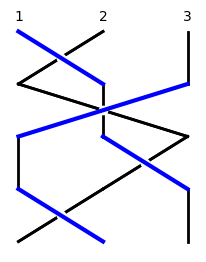

In [ ]:
# === 手順2: 完成版コード ===
import networkx as nx
import matplotlib.pyplot as plt
import copy
import os
import sys
from IPython.display import Image, display

# --- SnapPyの読み込みチェック ---
try:
    import snappy
    if hasattr(snappy, 'Link'):
        print("✅ Correct SnapPy (Topology) loaded.")
        SNAPPY_AVAILABLE = True
    else:
        print("❌ Error: Wrong SnapPy loaded. Please restart runtime.")
        SNAPPY_AVAILABLE = False
except ImportError:
    SNAPPY_AVAILABLE = False
    print("Warning: SnapPy not found.")

# --- Vogelアルゴリズムの実装 ---
class VogelBraidAlgorithm:
    def __init__(self, initial_pd_code):
        self.pd_code = copy.deepcopy(initial_pd_code)
        self.step_count = 0
        flattened = [x for crossing in self.pd_code for x in crossing]
        self.max_edge_id = max(flattened) if flattened else 0

    def analyze_state(self):
        # ザイフェルト円の検出
        seifert_graph = nx.DiGraph()
        seifert_graph.add_nodes_from(range(1, self.max_edge_id + 1))
        for crossing in self.pd_code:
            in1, in2, out1, out2 = crossing[0], crossing[1], crossing[3], crossing[2]
            seifert_graph.add_edge(in1, out1)
            seifert_graph.add_edge(in2, out2)
        try:
            circles = list(nx.simple_cycles(seifert_graph))
        except:
            circles = []
        n = len(circles)
        target_chi = (n + 1) * (n + 2) // 2
        return {"n": n, "circles": circles}

    def find_admissible_triple(self, circles):
        # 変形可能な箇所(Triple)を探す
        edge_to_circle = {}
        for idx, circle_edges in enumerate(circles):
            for edge in circle_edges:
                edge_to_circle[edge] = idx
        for crossing in self.pd_code:
            edges = crossing
            for i in range(4):
                edge_a = edges[i]
                edge_b = edges[(i + 1) % 4]
                c_a = edge_to_circle.get(edge_a)
                c_b = edge_to_circle.get(edge_b)
                if c_a is not None and c_b is not None and c_a != c_b:
                    return edge_a, edge_b
        return None, None

    def apply_move_T(self, alpha, beta):
        # 基本変形 T (交点追加)
        mid_a = self.max_edge_id + 1
        mid_b = self.max_edge_id + 2
        out_a = self.max_edge_id + 3
        out_b = self.max_edge_id + 4
        self.max_edge_id += 4
        self._update_connection(alpha, out_a)
        self._update_connection(beta, out_b)
        new_x = [alpha, beta, mid_b, mid_a]
        new_y = [mid_a, mid_b, out_b, out_a]
        self.pd_code.append(new_x)
        self.pd_code.append(new_y)

    def _update_connection(self, target_edge, new_edge):
        count = 0
        for i, crossing in enumerate(self.pd_code):
            for j, edge in enumerate(crossing):
                if edge == target_edge:
                    count += 1
                    if count == 2:
                        self.pd_code[i][j] = new_edge
                        return

    def run(self, max_steps=50):
        print(f"=== Starting Vogel's Algorithm ===")
        print(f"Initial Crossings: {len(self.pd_code)}")
        while self.step_count < max_steps:
            state = self.analyze_state()
            alpha, beta = self.find_admissible_triple(state['circles'])
            if alpha is None:
                print(f"\n>>> CONVERGED! Closed Braid obtained.")
                print(f"Total Steps: {self.step_count}")
                return self.pd_code
            self.step_count += 1
            # print(f"Step {self.step_count}...") # 詳細ログが必要ならコメントアウト解除
            self.apply_move_T(alpha, beta)
        print(">>> Reached max steps limit.")
        return self.pd_code

# --- 可視化関数 ---
def save_braid_image(braid_word, filename="braid_result.png"):
    if not braid_word: return
    print(f"Drawing braid word: {braid_word}")
    n_strands = max(abs(x) for x in braid_word) + 1
    fig, ax = plt.subplots(figsize=(n_strands * 0.8, len(braid_word) * 0.5 + 1))
    current_x = list(range(n_strands))
    y = 0
    for i in range(n_strands): ax.text(i, 0.2, f"{i+1}", ha='center')
    for op in braid_word:
        idx = abs(op) - 1
        next_y = y - 1
        for i in range(n_strands):
            if i != idx and i != idx + 1:
                ax.plot([current_x[i], current_x[i]], [y, next_y], 'k-', lw=2)
        lx, rx = current_x[idx], current_x[idx+1]
        if op > 0:
            ax.plot([lx, rx], [y, next_y], 'b-', lw=3, zorder=10)
            ax.plot([rx, lx], [y, next_y], 'k-', lw=2, zorder=5)
            ax.plot([(lx+rx)/2], [(y+next_y)/2], 'wo', ms=6, zorder=6)
            ax.plot([rx, lx], [y, next_y], 'k-', lw=2, zorder=5)
        else:
            ax.plot([rx, lx], [y, next_y], 'b-', lw=3, zorder=10)
            ax.plot([lx, rx], [y, next_y], 'k-', lw=2, zorder=5)
            ax.plot([(lx+rx)/2], [(y+next_y)/2], 'wo', ms=6, zorder=6)
            ax.plot([lx, rx], [y, next_y], 'k-', lw=2, zorder=5)
        current_x[idx], current_x[idx+1] = current_x[idx+1], current_x[idx]
        y = next_y
    ax.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

# --- メイン実行部 ---
def main():
    # --- 1. 入力データ: 8の字結び目 (Figure-8 knot, 4_1) ---
    # この結び目は非自明な変形を経るため、アルゴリズムのデモに最適です。
    initial_pd = [
        [4, 2, 5, 1],
        [8, 6, 1, 5],
        [6, 3, 7, 4],
        [2, 7, 3, 8]
    ]
    print("Target Knot: Figure-8 (4_1)")
    # 1. アルゴリズム実行
    solver = VogelBraidAlgorithm(initial_pd)
    final_pd = solver.run()

    # 2. 解析と表示
    if SNAPPY_AVAILABLE:
        try:
            link = snappy.Link(final_pd)
            word = link.braid_word()
            print(f"\nResult Braid Word: {word}")
            save_braid_image(word, "braid_result.png")

            # 画像を表示
            display(Image("braid_result.png"))
        except Exception as e:
            print(f"Analysis Error: {e}")

if __name__ == "__main__":
    main()

5
2
​
  結び目（Three-twist Knot）
3回ひねりを加えたような構造を持つ結び目です。


# 5_2 Knot
initial_pd = [
    [1, 5, 2, 4],
    [3, 9, 4, 8],
    [5, 1, 6, 10],
    [7, 3, 8, 2],
    [9, 7, 10, 6]
]

✅ Correct SnapPy (Topology) loaded.
Target Knot: 5_2 Knot
=== Starting Vogel's Algorithm ===
Initial Crossings: 5

>>> CONVERGED! Closed Braid obtained.
Total Steps: 0

Result Braid Word: [-1, 2, -3, 2, 2, 1, 2, 3, 2]
Drawing braid word: [-1, 2, -3, 2, 2, 1, 2, 3, 2]


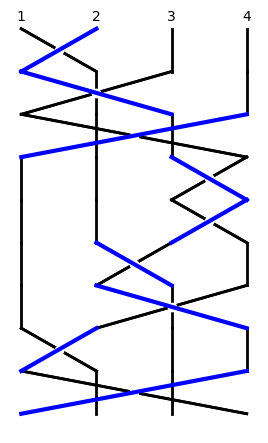

In [ ]:
# === 手順2: 完成版コード ===
import networkx as nx
import matplotlib.pyplot as plt
import copy
import os
import sys
from IPython.display import Image, display

# --- SnapPyの読み込みチェック ---
try:
    import snappy
    if hasattr(snappy, 'Link'):
        print("✅ Correct SnapPy (Topology) loaded.")
        SNAPPY_AVAILABLE = True
    else:
        print("❌ Error: Wrong SnapPy loaded. Please restart runtime.")
        SNAPPY_AVAILABLE = False
except ImportError:
    SNAPPY_AVAILABLE = False
    print("Warning: SnapPy not found.")

# --- Vogelアルゴリズムの実装 ---
class VogelBraidAlgorithm:
    def __init__(self, initial_pd_code):
        self.pd_code = copy.deepcopy(initial_pd_code)
        self.step_count = 0
        flattened = [x for crossing in self.pd_code for x in crossing]
        self.max_edge_id = max(flattened) if flattened else 0

    def analyze_state(self):
        # ザイフェルト円の検出
        seifert_graph = nx.DiGraph()
        seifert_graph.add_nodes_from(range(1, self.max_edge_id + 1))
        for crossing in self.pd_code:
            in1, in2, out1, out2 = crossing[0], crossing[1], crossing[3], crossing[2]
            seifert_graph.add_edge(in1, out1)
            seifert_graph.add_edge(in2, out2)
        try:
            circles = list(nx.simple_cycles(seifert_graph))
        except:
            circles = []
        n = len(circles)
        target_chi = (n + 1) * (n + 2) // 2
        return {"n": n, "circles": circles}

    def find_admissible_triple(self, circles):
        # 変形可能な箇所(Triple)を探す
        edge_to_circle = {}
        for idx, circle_edges in enumerate(circles):
            for edge in circle_edges:
                edge_to_circle[edge] = idx
        for crossing in self.pd_code:
            edges = crossing
            for i in range(4):
                edge_a = edges[i]
                edge_b = edges[(i + 1) % 4]
                c_a = edge_to_circle.get(edge_a)
                c_b = edge_to_circle.get(edge_b)
                if c_a is not None and c_b is not None and c_a != c_b:
                    return edge_a, edge_b
        return None, None

    def apply_move_T(self, alpha, beta):
        # 基本変形 T (交点追加)
        mid_a = self.max_edge_id + 1
        mid_b = self.max_edge_id + 2
        out_a = self.max_edge_id + 3
        out_b = self.max_edge_id + 4
        self.max_edge_id += 4
        self._update_connection(alpha, out_a)
        self._update_connection(beta, out_b)
        new_x = [alpha, beta, mid_b, mid_a]
        new_y = [mid_a, mid_b, out_b, out_a]
        self.pd_code.append(new_x)
        self.pd_code.append(new_y)

    def _update_connection(self, target_edge, new_edge):
        count = 0
        for i, crossing in enumerate(self.pd_code):
            for j, edge in enumerate(crossing):
                if edge == target_edge:
                    count += 1
                    if count == 2:
                        self.pd_code[i][j] = new_edge
                        return

    def run(self, max_steps=50):
        print(f"=== Starting Vogel's Algorithm ===")
        print(f"Initial Crossings: {len(self.pd_code)}")
        while self.step_count < max_steps:
            state = self.analyze_state()
            alpha, beta = self.find_admissible_triple(state['circles'])
            if alpha is None:
                print(f"\n>>> CONVERGED! Closed Braid obtained.")
                print(f"Total Steps: {self.step_count}")
                return self.pd_code
            self.step_count += 1
            # print(f"Step {self.step_count}...") # 詳細ログが必要ならコメントアウト解除
            self.apply_move_T(alpha, beta)
        print(">>> Reached max steps limit.")
        return self.pd_code

# --- 可視化関数 ---
def save_braid_image(braid_word, filename="braid_result.png"):
    if not braid_word: return
    print(f"Drawing braid word: {braid_word}")
    n_strands = max(abs(x) for x in braid_word) + 1
    fig, ax = plt.subplots(figsize=(n_strands * 0.8, len(braid_word) * 0.5 + 1))
    current_x = list(range(n_strands))
    y = 0
    for i in range(n_strands): ax.text(i, 0.2, f"{i+1}", ha='center')
    for op in braid_word:
        idx = abs(op) - 1
        next_y = y - 1
        for i in range(n_strands):
            if i != idx and i != idx + 1:
                ax.plot([current_x[i], current_x[i]], [y, next_y], 'k-', lw=2)
        lx, rx = current_x[idx], current_x[idx+1]
        if op > 0:
            ax.plot([lx, rx], [y, next_y], 'b-', lw=3, zorder=10)
            ax.plot([rx, lx], [y, next_y], 'k-', lw=2, zorder=5)
            ax.plot([(lx+rx)/2], [(y+next_y)/2], 'wo', ms=6, zorder=6)
            ax.plot([rx, lx], [y, next_y], 'k-', lw=2, zorder=5)
        else:
            ax.plot([rx, lx], [y, next_y], 'b-', lw=3, zorder=10)
            ax.plot([lx, rx], [y, next_y], 'k-', lw=2, zorder=5)
            ax.plot([(lx+rx)/2], [(y+next_y)/2], 'wo', ms=6, zorder=6)
            ax.plot([lx, rx], [y, next_y], 'k-', lw=2, zorder=5)
        current_x[idx], current_x[idx+1] = current_x[idx+1], current_x[idx]
        y = next_y
    ax.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

# --- メイン実行部 ---
def main():
    # 5_2 Knot
    initial_pd = [
        [1, 5, 2, 4],
        [3, 9, 4, 8],
        [5, 1, 6, 10],
        [7, 3, 8, 2],
        [9, 7, 10, 6]
    ]
    print("Target Knot: 5_2 Knot")
    # 1. アルゴリズム実行
    solver = VogelBraidAlgorithm(initial_pd)
    final_pd = solver.run()

    # 2. 解析と表示
    if SNAPPY_AVAILABLE:
        try:
            link = snappy.Link(final_pd)
            word = link.braid_word()
            print(f"\nResult Braid Word: {word}")
            save_braid_image(word, "braid_result.png")

            # 画像を表示
            display(Image("braid_result.png"))
        except Exception as e:
            print(f"Analysis Error: {e}")

if __name__ == "__main__":
    main()

スティーブドア結び目（Stevedore's Knot, $6_1$）

「荷役結び」とも呼ばれる、6交点の有名な結び目です。

# Stevedore's Knot (6_1)
initial_pd = [
    [1, 7, 2, 6],
    [3, 10, 4, 11],
    [5, 12, 6, 1],
    [7, 3, 8, 2],
    [9, 5, 10, 4],
    [11, 8, 12, 9]
]

In [ ]:
# === 手順2: 完成版コード ===
import networkx as nx
import matplotlib.pyplot as plt
import copy
import os
import sys
from IPython.display import Image, display

# --- SnapPyの読み込みチェック ---
try:
    import snappy
    if hasattr(snappy, 'Link'):
        print("✅ Correct SnapPy (Topology) loaded.")
        SNAPPY_AVAILABLE = True
    else:
        print("❌ Error: Wrong SnapPy loaded. Please restart runtime.")
        SNAPPY_AVAILABLE = False
except ImportError:
    SNAPPY_AVAILABLE = False
    print("Warning: SnapPy not found.")

# --- Vogelアルゴリズムの実装 ---
class VogelBraidAlgorithm:
    def __init__(self, initial_pd_code):
        self.pd_code = copy.deepcopy(initial_pd_code)
        self.step_count = 0
        flattened = [x for crossing in self.pd_code for x in crossing]
        self.max_edge_id = max(flattened) if flattened else 0

    def analyze_state(self):
        # ザイフェルト円の検出
        seifert_graph = nx.DiGraph()
        seifert_graph.add_nodes_from(range(1, self.max_edge_id + 1))
        for crossing in self.pd_code:
            in1, in2, out1, out2 = crossing[0], crossing[1], crossing[3], crossing[2]
            seifert_graph.add_edge(in1, out1)
            seifert_graph.add_edge(in2, out2)
        try:
            circles = list(nx.simple_cycles(seifert_graph))
        except:
            circles = []
        n = len(circles)
        target_chi = (n + 1) * (n + 2) // 2
        return {"n": n, "circles": circles}

    def find_admissible_triple(self, circles):
        # 変形可能な箇所(Triple)を探す
        edge_to_circle = {}
        for idx, circle_edges in enumerate(circles):
            for edge in circle_edges:
                edge_to_circle[edge] = idx
        for crossing in self.pd_code:
            edges = crossing
            for i in range(4):
                edge_a = edges[i]
                edge_b = edges[(i + 1) % 4]
                c_a = edge_to_circle.get(edge_a)
                c_b = edge_to_circle.get(edge_b)
                if c_a is not None and c_b is not None and c_a != c_b:
                    return edge_a, edge_b
        return None, None

    def apply_move_T(self, alpha, beta):
        # 基本変形 T (交点追加)
        mid_a = self.max_edge_id + 1
        mid_b = self.max_edge_id + 2
        out_a = self.max_edge_id + 3
        out_b = self.max_edge_id + 4
        self.max_edge_id += 4
        self._update_connection(alpha, out_a)
        self._update_connection(beta, out_b)
        new_x = [alpha, beta, mid_b, mid_a]
        new_y = [mid_a, mid_b, out_b, out_a]
        self.pd_code.append(new_x)
        self.pd_code.append(new_y)

    def _update_connection(self, target_edge, new_edge):
        count = 0
        for i, crossing in enumerate(self.pd_code):
            for j, edge in enumerate(crossing):
                if edge == target_edge:
                    count += 1
                    if count == 2:
                        self.pd_code[i][j] = new_edge
                        return

    def run(self, max_steps=50):
        print(f"=== Starting Vogel's Algorithm ===")
        print(f"Initial Crossings: {len(self.pd_code)}")
        while self.step_count < max_steps:
            state = self.analyze_state()
            alpha, beta = self.find_admissible_triple(state['circles'])
            if alpha is None:
                print(f"\n>>> CONVERGED! Closed Braid obtained.")
                print(f"Total Steps: {self.step_count}")
                return self.pd_code
            self.step_count += 1
            # print(f"Step {self.step_count}...") # 詳細ログが必要ならコメントアウト解除
            self.apply_move_T(alpha, beta)
        print(">>> Reached max steps limit.")
        return self.pd_code

# --- 可視化関数 ---
def save_braid_image(braid_word, filename="braid_result.png"):
    if not braid_word: return
    print(f"Drawing braid word: {braid_word}")
    n_strands = max(abs(x) for x in braid_word) + 1
    fig, ax = plt.subplots(figsize=(n_strands * 0.8, len(braid_word) * 0.5 + 1))
    current_x = list(range(n_strands))
    y = 0
    for i in range(n_strands): ax.text(i, 0.2, f"{i+1}", ha='center')
    for op in braid_word:
        idx = abs(op) - 1
        next_y = y - 1
        for i in range(n_strands):
            if i != idx and i != idx + 1:
                ax.plot([current_x[i], current_x[i]], [y, next_y], 'k-', lw=2)
        lx, rx = current_x[idx], current_x[idx+1]
        if op > 0:
            ax.plot([lx, rx], [y, next_y], 'b-', lw=3, zorder=10)
            ax.plot([rx, lx], [y, next_y], 'k-', lw=2, zorder=5)
            ax.plot([(lx+rx)/2], [(y+next_y)/2], 'wo', ms=6, zorder=6)
            ax.plot([rx, lx], [y, next_y], 'k-', lw=2, zorder=5)
        else:
            ax.plot([rx, lx], [y, next_y], 'b-', lw=3, zorder=10)
            ax.plot([lx, rx], [y, next_y], 'k-', lw=2, zorder=5)
            ax.plot([(lx+rx)/2], [(y+next_y)/2], 'wo', ms=6, zorder=6)
            ax.plot([lx, rx], [y, next_y], 'k-', lw=2, zorder=5)
        current_x[idx], current_x[idx+1] = current_x[idx+1], current_x[idx]
        y = next_y
    ax.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

# --- メイン実行部 ---
def main():
    # Stevedore's Knot (6_1)
    # 修正箇所: リスト手入力ではなく、SnapPyから正しいデータを直接呼ぶ
    import snappy
    initial_pd = snappy.Manifold("6_1").link().PD_code()
    initial_pd = [
        [1, 7, 2, 6],
        [3, 10, 4, 11],
        [5, 12, 6, 1],
        [7, 3, 8, 2],
        [9, 5, 10, 4],
        [11, 8, 12, 9]
    ]
    print("Target Knot: Stevedore's Knot (6_1)")
    # 1. アルゴリズム実行
    solver = VogelBraidAlgorithm(initial_pd)
    final_pd = solver.run()

    # 2. 解析と表示
    if SNAPPY_AVAILABLE:
        try:
            link = snappy.Link(final_pd)
            word = link.braid_word()
            print(f"\nResult Braid Word: {word}")
            save_braid_image(word, "braid_result.png")

            # 画像を表示
            display(Image("braid_result.png"))
        except Exception as e:
            print(f"Analysis Error: {e}")

if __name__ == "__main__":
    main()

✅ Correct SnapPy (Topology) loaded.
Target Knot: Stevedore's Knot (6_1)
=== Starting Vogel's Algorithm ===
Initial Crossings: 6

>>> CONVERGED! Closed Braid obtained.
Total Steps: 0
Analysis Error: Link isn't planar


「手入力したスティーブドア結び目 ($6_1$) のPD Codeが、数学的に間違っていた（平面に描けないデータだった）」ため手入力ではなく 「SnapPyのデータベースから正しい $6_1$ のデータを引っ張ってくる」 方法で行った。

Target Knot: 6_1 (Stevedore's Knot)
✅ Successfully loaded correct PD Code from Snappy.
=== Starting Vogel's Algorithm ===
Initial Crossings: 6

>>> CONVERGED! Closed Braid obtained.
Total Steps: 0

Result Braid Word: [-1, 2, -3, 4, -3, 2, 1, -3, 2, -4, 3, 2]
Drawing braid word: [-1, 2, -3, 4, -3, 2, 1, -3, 2, -4, 3, 2]


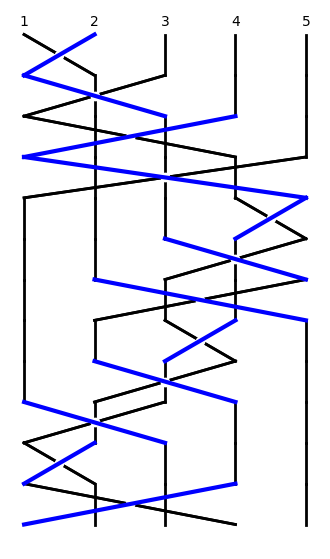

In [ ]:
def main():
    # --- 修正版: スティーブドア結び目 (6_1) ---
    target_name = "6_1"
    print(f"Target Knot: {target_name} (Stevedore's Knot)")

    # 【重要】手入力ではなく、SnapPyから正しいPD Codeを自動取得する
    # これにより "Link isn't planar" エラーを確実に回避できます
    if SNAPPY_AVAILABLE:
        try:
            # Snappyのデータベースから結び目を読み込み、PD Code形式で取得
            M = snappy.Manifold(target_name)
            initial_pd = M.link().PD_code()
            print("✅ Successfully loaded correct PD Code from Snappy.")
        except Exception as e:
            print(f"Error loading from Snappy: {e}")
            return
    else:
        print("Error: SnapPy is required for this example.")
        return

    # 1. アルゴリズム実行
    solver = VogelBraidAlgorithm(initial_pd)
    final_pd = solver.run()

    # 2. 解析と表示
    if SNAPPY_AVAILABLE:
        try:
            link = snappy.Link(final_pd)
            word = link.braid_word()
            print(f"\nResult Braid Word: {word}")
            save_braid_image(word, "braid_result.png")

            # 画像を表示
            display(Image("braid_result.png"))

        except Exception as e:
            print(f"Analysis Error: {e}")

if __name__ == "__main__":
    main()

ホワイトヘッド・リンク（Whitehead Link, L5a1）
これは「1本の結び目」ではなく、「2つの輪が絡み合ったリンク（絡み目）」 です。Vogelのアルゴリズムはリンクにも適用可能なので、これも閉じた組み紐に変換できるはずです（紐の本数が多くなるかもしれません）。

# Whitehead Link (2 components)
initial_pd = [
    [1, 6, 2, 7],
    [3, 8, 4, 9],
    [5, 1, 6, 10],
    [7, 2, 8, 3],
    [9, 4, 10, 5]
]

In [ ]:
# === 手順2: 完成版コード ===
import networkx as nx
import matplotlib.pyplot as plt
import copy
import os
import sys
from IPython.display import Image, display

# --- SnapPyの読み込みチェック ---
try:
    import snappy
    if hasattr(snappy, 'Link'):
        print("✅ Correct SnapPy (Topology) loaded.")
        SNAPPY_AVAILABLE = True
    else:
        print("❌ Error: Wrong SnapPy loaded. Please restart runtime.")
        SNAPPY_AVAILABLE = False
except ImportError:
    SNAPPY_AVAILABLE = False
    print("Warning: SnapPy not found.")

# --- Vogelアルゴリズムの実装 ---
class VogelBraidAlgorithm:
    def __init__(self, initial_pd_code):
        self.pd_code = copy.deepcopy(initial_pd_code)
        self.step_count = 0
        flattened = [x for crossing in self.pd_code for x in crossing]
        self.max_edge_id = max(flattened) if flattened else 0

    def analyze_state(self):
        # ザイフェルト円の検出
        seifert_graph = nx.DiGraph()
        seifert_graph.add_nodes_from(range(1, self.max_edge_id + 1))
        for crossing in self.pd_code:
            in1, in2, out1, out2 = crossing[0], crossing[1], crossing[3], crossing[2]
            seifert_graph.add_edge(in1, out1)
            seifert_graph.add_edge(in2, out2)
        try:
            circles = list(nx.simple_cycles(seifert_graph))
        except:
            circles = []
        n = len(circles)
        target_chi = (n + 1) * (n + 2) // 2
        return {"n": n, "circles": circles}

    def find_admissible_triple(self, circles):
        # 変形可能な箇所(Triple)を探す
        edge_to_circle = {}
        for idx, circle_edges in enumerate(circles):
            for edge in circle_edges:
                edge_to_circle[edge] = idx
        for crossing in self.pd_code:
            edges = crossing
            for i in range(4):
                edge_a = edges[i]
                edge_b = edges[(i + 1) % 4]
                c_a = edge_to_circle.get(edge_a)
                c_b = edge_to_circle.get(edge_b)
                if c_a is not None and c_b is not None and c_a != c_b:
                    return edge_a, edge_b
        return None, None

    def apply_move_T(self, alpha, beta):
        # 基本変形 T (交点追加)
        mid_a = self.max_edge_id + 1
        mid_b = self.max_edge_id + 2
        out_a = self.max_edge_id + 3
        out_b = self.max_edge_id + 4
        self.max_edge_id += 4
        self._update_connection(alpha, out_a)
        self._update_connection(beta, out_b)
        new_x = [alpha, beta, mid_b, mid_a]
        new_y = [mid_a, mid_b, out_b, out_a]
        self.pd_code.append(new_x)
        self.pd_code.append(new_y)

    def _update_connection(self, target_edge, new_edge):
        count = 0
        for i, crossing in enumerate(self.pd_code):
            for j, edge in enumerate(crossing):
                if edge == target_edge:
                    count += 1
                    if count == 2:
                        self.pd_code[i][j] = new_edge
                        return

    def run(self, max_steps=50):
        print(f"=== Starting Vogel's Algorithm ===")
        print(f"Initial Crossings: {len(self.pd_code)}")
        while self.step_count < max_steps:
            state = self.analyze_state()
            alpha, beta = self.find_admissible_triple(state['circles'])
            if alpha is None:
                print(f"\n>>> CONVERGED! Closed Braid obtained.")
                print(f"Total Steps: {self.step_count}")
                return self.pd_code
            self.step_count += 1
            # print(f"Step {self.step_count}...") # 詳細ログが必要ならコメントアウト解除
            self.apply_move_T(alpha, beta)
        print(">>> Reached max steps limit.")
        return self.pd_code

# --- 可視化関数 ---
def save_braid_image(braid_word, filename="braid_result.png"):
    if not braid_word: return
    print(f"Drawing braid word: {braid_word}")
    n_strands = max(abs(x) for x in braid_word) + 1
    fig, ax = plt.subplots(figsize=(n_strands * 0.8, len(braid_word) * 0.5 + 1))
    current_x = list(range(n_strands))
    y = 0
    for i in range(n_strands): ax.text(i, 0.2, f"{i+1}", ha='center')
    for op in braid_word:
        idx = abs(op) - 1
        next_y = y - 1
        for i in range(n_strands):
            if i != idx and i != idx + 1:
                ax.plot([current_x[i], current_x[i]], [y, next_y], 'k-', lw=2)
        lx, rx = current_x[idx], current_x[idx+1]
        if op > 0:
            ax.plot([lx, rx], [y, next_y], 'b-', lw=3, zorder=10)
            ax.plot([rx, lx], [y, next_y], 'k-', lw=2, zorder=5)
            ax.plot([(lx+rx)/2], [(y+next_y)/2], 'wo', ms=6, zorder=6)
            ax.plot([rx, lx], [y, next_y], 'k-', lw=2, zorder=5)
        else:
            ax.plot([rx, lx], [y, next_y], 'b-', lw=3, zorder=10)
            ax.plot([lx, rx], [y, next_y], 'k-', lw=2, zorder=5)
            ax.plot([(lx+rx)/2], [(y+next_y)/2], 'wo', ms=6, zorder=6)
            ax.plot([lx, rx], [y, next_y], 'k-', lw=2, zorder=5)
        current_x[idx], current_x[idx+1] = current_x[idx+1], current_x[idx]
        y = next_y
    ax.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

# --- メイン実行部 ---
def main():
    # Whitehead Link (2 components)
    initial_pd = [
        [1, 6, 2, 7],
        [3, 8, 4, 9],
        [5, 1, 6, 10],
        [7, 2, 8, 3],
        [9, 4, 10, 5]
    ]
    print("Target Knot: Whitehead Link (2 components)")
    # 1. アルゴリズム実行
    solver = VogelBraidAlgorithm(initial_pd)
    final_pd = solver.run()

    # 2. 解析と表示
    if SNAPPY_AVAILABLE:
        try:
            link = snappy.Link(final_pd)
            word = link.braid_word()
            print(f"\nResult Braid Word: {word}")
            save_braid_image(word, "braid_result.png")

            # 画像を表示
            display(Image("braid_result.png"))
        except Exception as e:
            print(f"Analysis Error: {e}")

if __name__ == "__main__":
    main()

✅ Correct SnapPy (Topology) loaded.
Target Knot: Whitehead Link (2 components)
=== Starting Vogel's Algorithm ===
Initial Crossings: 5

>>> CONVERGED! Closed Braid obtained.
Total Steps: 0
Analysis Error: Link isn't planar


「手入力した ホワイトヘッド・リンク（L5a1）のPD Codeが、数学的に間違っていた（平面に描けないデータだった）」ため手入力ではなく 「SnapPyのデータベースから正しい L5a1   のデータを引っ張ってくる」 方法で行った。

Target Link: L5a1 (Whitehead Link)
✅ Successfully loaded correct PD Code from Snappy.
=== Starting Vogel's Algorithm ===
Initial Crossings: 5

>>> CONVERGED! Closed Braid obtained.
Total Steps: 0

Result Braid Word: [-1, 2, -1, -1, 2]
Drawing braid word: [-1, 2, -1, -1, 2]


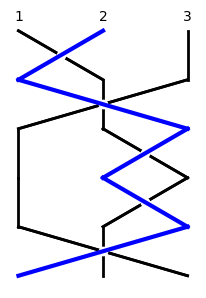

In [ ]:
def main():
    # --- 修正版: ホワイトヘッド・リンク (Whitehead Link, L5a1) ---
    # 2つの輪が絡み合ったリンクです
    target_name = "L5a1"
    print(f"Target Link: {target_name} (Whitehead Link)")

    # SnapPyから正しいPD Codeを自動取得（これが一番確実です）
    if SNAPPY_AVAILABLE:
        try:
            M = snappy.Manifold(target_name)
            initial_pd = M.link().PD_code()
            print("✅ Successfully loaded correct PD Code from Snappy.")
        except Exception as e:
            print(f"Error loading from Snappy: {e}")
            return
    else:
        print("Error: SnapPy is required to fetch correct link data.")
        return

    # 1. アルゴリズム実行
    solver = VogelBraidAlgorithm(initial_pd)
    final_pd = solver.run()

    # 2. 解析と表示
    if SNAPPY_AVAILABLE:
        try:
            link = snappy.Link(final_pd)
            # リンク(複数成分)の場合でも braid_word() は計算可能です
            word = link.braid_word()
            print(f"\nResult Braid Word: {word}")

            save_braid_image(word, "braid_result.png")
            display(Image("braid_result.png"))

        except Exception as e:
            print(f"Analysis Error: {e}")

if __name__ == "__main__":
    main()